# Cytometry Clustering Comparison Project



In [ ]:
import pandas as pd
import flowsom as fs
import numpy as np
from FlowGrid import FlowGrid
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
import time

## 1. Dataset Loading and Initial Analysis


In [ ]:


# Read the two datasets
data_markers = pd.read_csv("datasets/human_blood_mass_cytometry_batch1.csv", index_col=0)      
data_celltypes = pd.read_csv("datasets/human_blood_mass_cytometry_batch1_metadata.csv")  
labels_true = data_celltypes["cell_type"].values

df = data_markers.copy()
df = pd.concat([data_markers, data_celltypes], axis=1)
print(df.info())
print(df.head())
print(df.describe())
        

start = np.random.randint(0, len(data_markers) - 40000 + 1)
X_sample = data_markers.iloc[start:start+40000]
labels_true_sample = labels_true[start:start+40000]

<class 'pandas.core.frame.DataFrame'>
Index: 481715 entries, 0 to 481714
Data columns (total 39 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   CD45       481715 non-null  float64
 1   CD66       481715 non-null  float64
 2   CD7        481715 non-null  float64
 3   CD45RA     481715 non-null  float64
 4   CD11b      481715 non-null  float64
 5   CD4        481715 non-null  float64
 6   CD8a       481715 non-null  float64
 7   CD11c      481715 non-null  float64
 8   CD123      481715 non-null  float64
 9   CREB       481715 non-null  float64
 10  STAT5      481715 non-null  float64
 11  p38        481715 non-null  float64
 12  TCRgd      481715 non-null  float64
 13  STAT1      481715 non-null  float64
 14  STAT3      481715 non-null  float64
 15  S6         481715 non-null  float64
 16  CXCR3      481715 non-null  float64
 17  CD161      481715 non-null  float64
 18  CD33       481715 non-null  float64
 19  MAPKAPK2   481715 non-null  

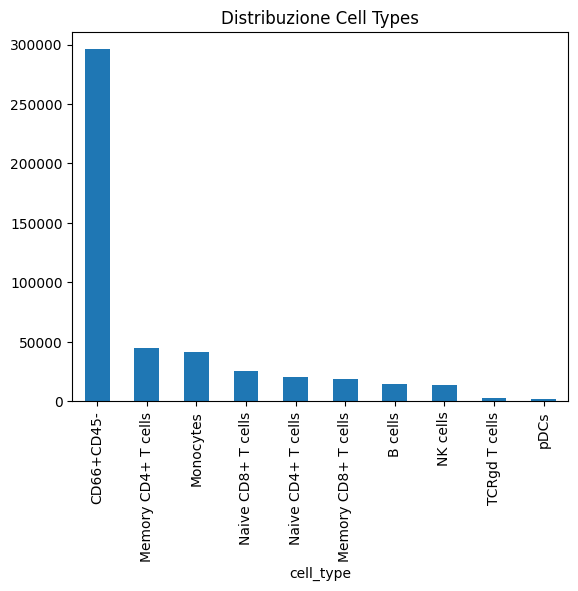

In [ ]:
df["cell_type"].value_counts().plot(kind="bar")
plt.title("Distribution Cell Types")
plt.show()


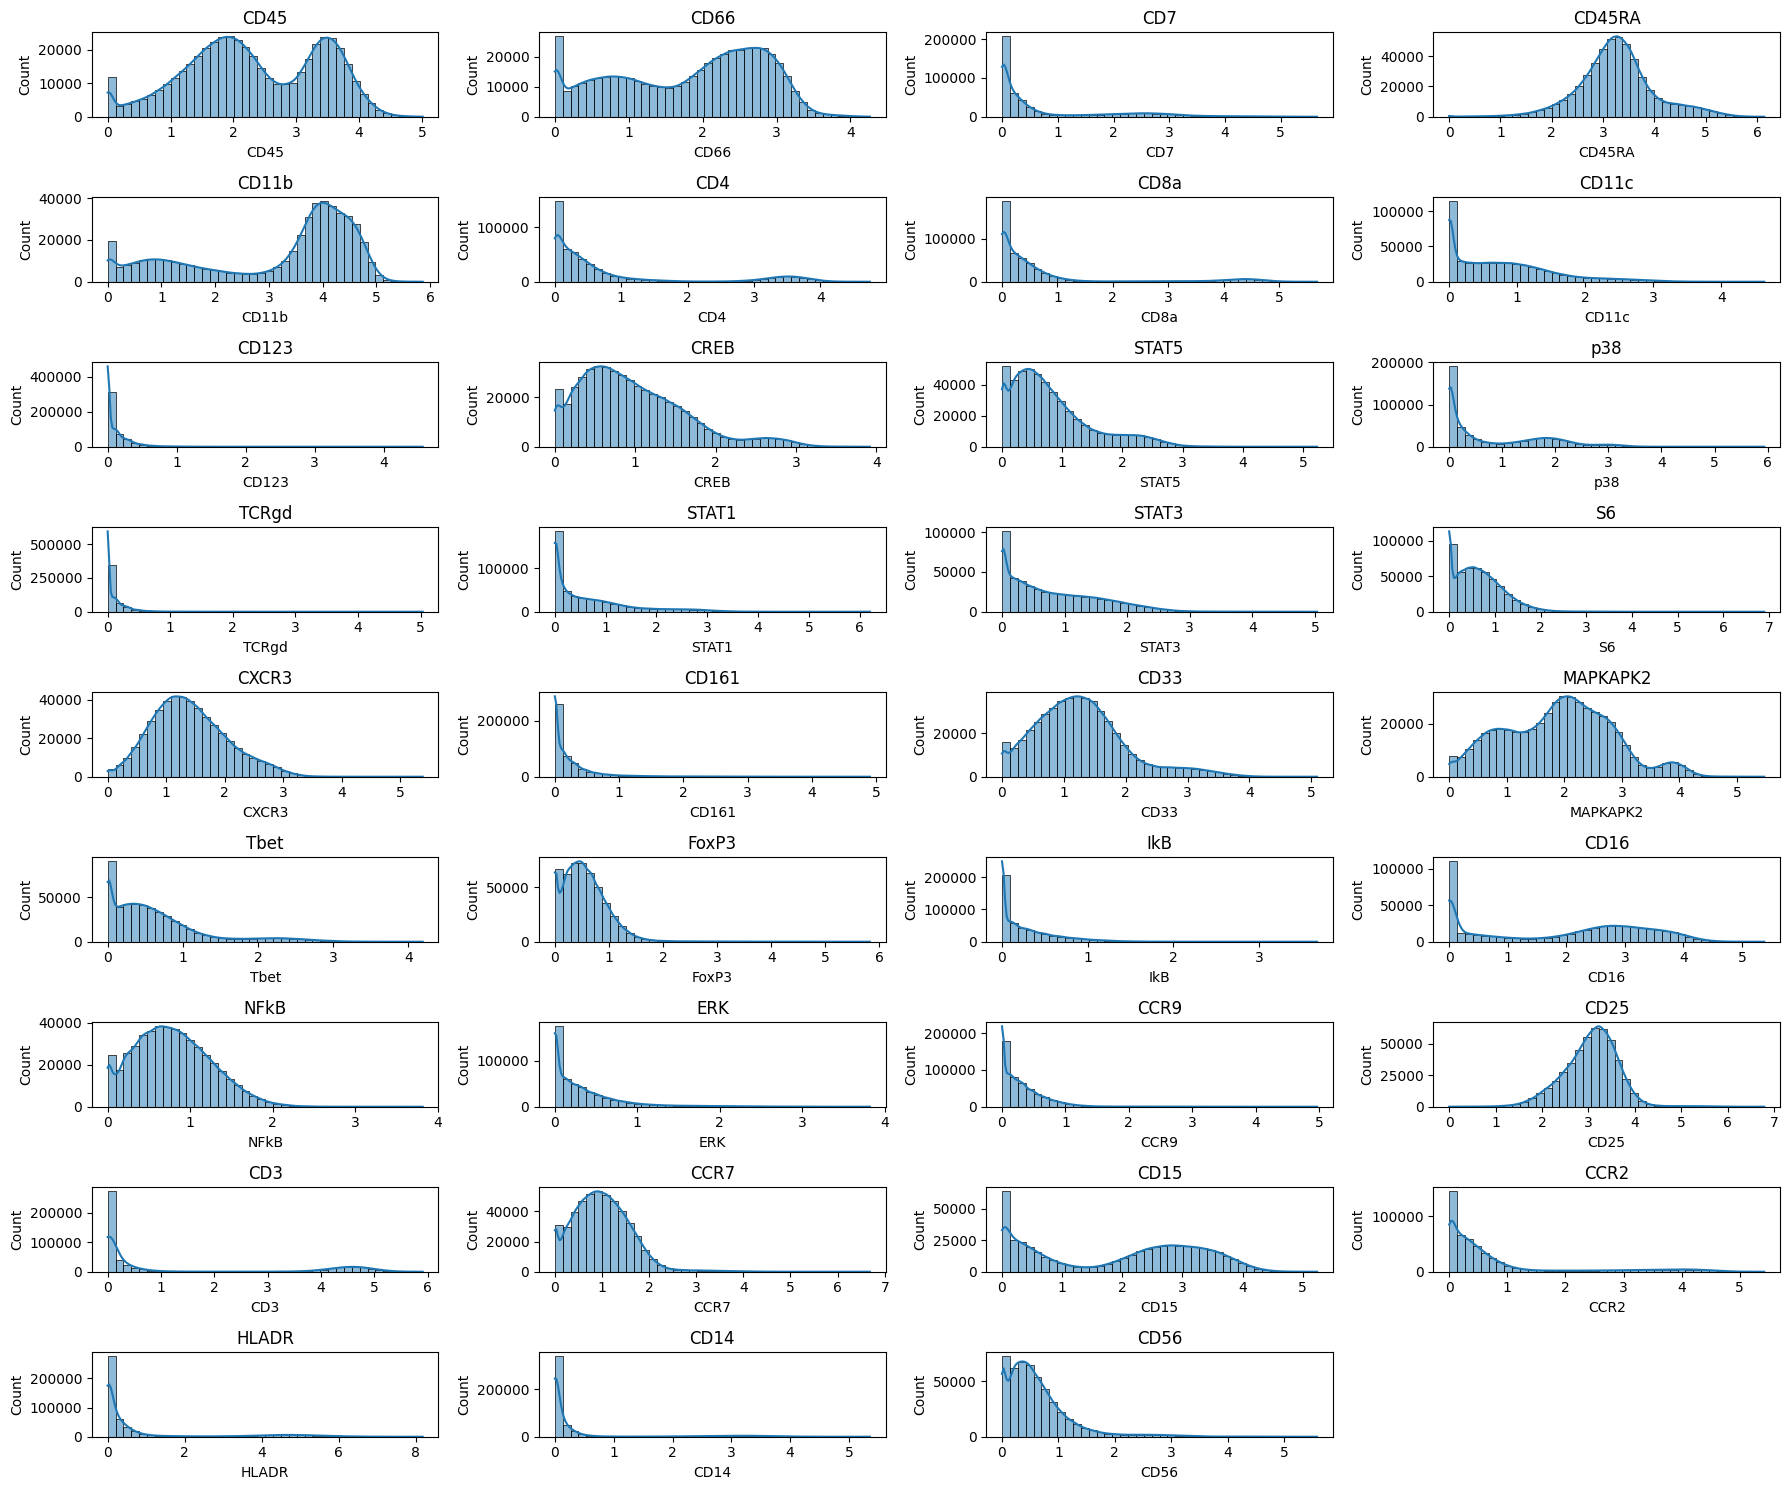

In [12]:
num_cols = data_markers.shape[1]
cols = data_markers.columns

plt.figure(figsize=(18, 15))

for i, col in enumerate(cols):
    plt.subplot((num_cols // 4) + 1, 4, i + 1)
    sns.histplot(data_markers[col], bins=40, kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

## 2. Dimensionality Reduction


c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Simone\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\Simone\AppData\Local\Temp\ipykernel_12964\2738019796.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


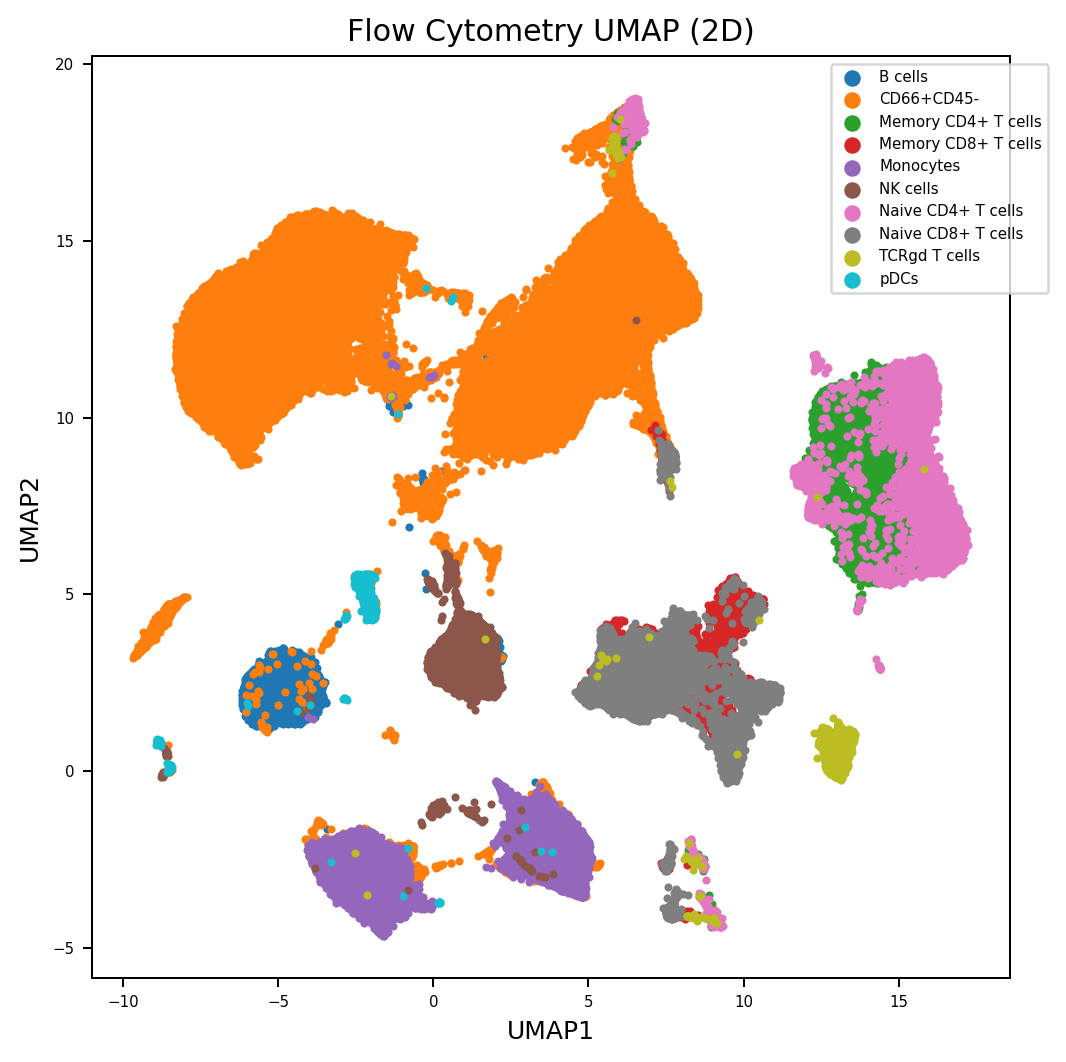

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import umap
import numpy as np


X = data_markers.values
y = labels_true  

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=10, min_dist=0.3)
X_umap = reducer.fit_transform(X)

unique_labels = np.unique(y)
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

palette = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

fig, ax = plt.subplots(dpi=180, figsize=(6, 6))  

for label in unique_labels:
    ax.scatter(
        X_umap[y == label, 0],
        X_umap[y == label, 1],
        s=5,  
        label=label,
        c=palette[label]
    )

ax.tick_params(axis='both', which='major', labelsize=6)
ax.legend(bbox_to_anchor=(1.05, 1), markerscale=2.5, fontsize=6)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('Flow Cytometry UMAP (2D)')
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.manifold import TSNE


X = data_markers.values
y = labels_true  

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X)

unique_labels = np.unique(y)
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
palette = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

# Plot
fig, ax = plt.subplots(dpi=180, figsize=(6,6))

for label in unique_labels:
    ax.scatter(
        X_tsne[y == label, 0],
        X_tsne[y == label, 1],
        s=5,
        label=label,
        c=palette[label]
    )

ax.tick_params(axis='both', which='major', labelsize=6)
ax.legend(bbox_to_anchor=(1.05, 1), markerscale=2.5, fontsize=6)
ax.set_xlabel('t-SNE1')
ax.set_ylabel('t-SNE2')
ax.set_title('Flow Cytometry t-SNE (2D)')
plt.tight_layout()
plt.savefig('tsneReduction.png')
plt.show()


## 3. Clustering Methods Implementation


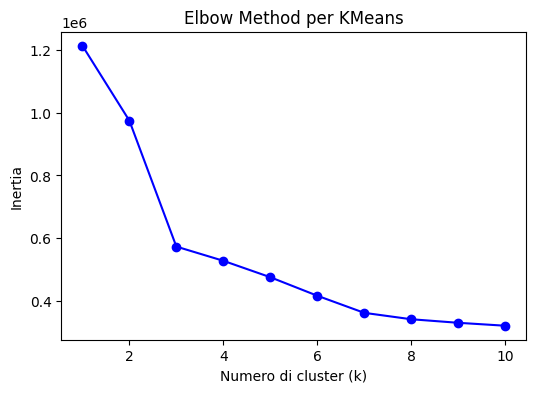

In [ ]:
inertia = []
k_range = range(1, 11)  
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sample)
    inertia.append(kmeans.inertia_)

In [ ]:

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_sample)

ari = adjusted_rand_score(labels_true_sample, labels)
nmi = normalized_mutual_info_score(labels_true_sample, labels)
silhouette = silhouette_score(X_sample, labels)

print(f"ARI: {ari:.3f} | NMI: {nmi:.3f} | Silhouette: {silhouette:.3f}")


In [ ]:

k_values = [2, 3, 4, 5, 6, 8, 10]
linkages = ['ward', 'average', 'complete']
metrics = {
    'ward': ['euclidean'],  
    'average': ['euclidean', 'manhattan', 'cosine'],
    'complete': ['euclidean', 'manhattan', 'cosine']
}

best_result = {
    "score": -1,
    "params": None
}

print("Testing parameters...\n")

for link in linkages:
    for k in k_values:
        for m in metrics[link]:

            if link == "ward" and m != "euclidean":
                continue

            agg = AgglomerativeClustering(
                n_clusters=k,
                linkage=link,
                metric=m if link != "ward" else "euclidean"
            )

            labels = agg.fit_predict(X_sample)

            score = adjusted_rand_score(labels_true_sample, labels)

            print(f"k={k:2d} | link={link:8s} | metric={m:9s} | ARI={score:.4f}")

            if score > best_result["score"]:
                best_result["score"] = score
                best_result["params"] = (k, link, m)

print("\n--- BEST PARAMETERS ---")
print("Silhouette:", best_result["score"])
print("k, linkage, metric:", best_result["params"])


Testing parameters...



In [ ]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


min_cluster_size_values = [5, 10, 15, 20]  
min_samples_values = [2, 5, 10, 15]           
metrics = ['euclidean', 'manhattan', 'cosine']

best = {"score": -1, "params": None}

print("\n--- Starting HDBSCAN Grid Search ---\n")

for min_cluster_size in min_cluster_size_values:
    for min_samples in min_samples_values:
        for metric in metrics:
            try:
                clusterer = HDBSCAN(
                    min_cluster_size=min_cluster_size,
                    min_samples=min_samples,
                    metric=metric
                )
                
                labels = clusterer.fit_predict(X_sample)
                
                if len(np.unique(labels)) <= 1:
                    ari = -1
                    nmi = -1
                else:
                    ari = adjusted_rand_score(labels_true_sample, labels)
                    nmi = normalized_mutual_info_score(labels_true_sample, labels)
                
                print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}, metric={metric} | ARI={ari:.4f} | NMI={nmi:.4f}")

                if ari > best["score"]:
                    best["score"] = ari
                    best["params"] = (min_cluster_size, min_samples, metric)

            except Exception as e:
                print(f"FAILED: min_cluster_size={min_cluster_size}, min_samples={min_samples}, metric={metric} | Error={e}")

print("\n--- BEST PARAMETERS FOUND ---")
print(best)





--- Starting HDBSCAN Grid Search ---



In [ ]:
eps_values = [1.0, 1.5, 2.0, 2.5, 3.0]      
min_samples_values = [5, 10, 15, 20]      
metrics = ['euclidean', 'manhattan', 'cosine']

best = {"score": -1, "params": None}

print("\n--- Starting DBSCAN Grid Search ---\n")

for eps in eps_values:
    for min_samples in min_samples_values:
        for metric in metrics:
            try:
                db = DBSCAN(
                    eps=eps,
                    min_samples=min_samples,
                    metric=metric,
                    n_jobs=-1
                )
                labels = db.fit_predict(X_sample)

                ari = adjusted_rand_score(labels_true_sample, labels)
                nmi = normalized_mutual_info_score(labels_true_sample, labels)

                print(f"eps={eps}, min_samples={min_samples}, metric={metric} | ARI={ari:.4f} | NMI={nmi:.4f}")

                if ari > best["score"]:
                    best["score"] = ari
                    best["params"] = (eps, min_samples, metric)

            except Exception as e:
                print(f"FAILED: eps={eps}, min_samples={min_samples}, metric={metric} | Error={e}")

print("\n--- BEST PARAMETERS FOUND ---")
print(best)



--- Starting DBSCAN Grid Search ---

eps=1.0, min_samples=5, metric=euclidean | ARI=0.0000 | NMI=0.0000


In [ ]:
xdims = [2,3,4,5,8, 10] 
ydims = [2,3,4,5,8, 10] 
n_clusters_list = [2,3,5,10,15,20] 
max_iters = [100, 125, 250, 500] 
learning_rates = [0.0015, 0.0025, 0.005, 0.01]   

best = {"score": -1, "params": None}

for xd in xdims:
    for yd in ydims:
        for nc in n_clusters_list:
            for it in max_iters:
                for lr in learning_rates:

                    try:
                        fsom = fs.FlowSOM(
                            X_sample,
                            cols_to_use=list(range(X_sample.shape[1])), 
                            xdim=xd,
                            ydim=yd,
                            n_clusters=nc,
                            max_iter=it,
                            learning_rate=lr,
                            seed=42
                        )

                        labels = fsom.cluster_labels
                        ari = adjusted_rand_score(labels_true_sample, labels)
                        nmi = normalized_mutual_info_score(labels_true_sample, labels)

                        print(f" → ARI={ari:.4f} | NMI={nmi:.4f}")

                        if ari > best["score"]:
                            best["score"] = ari
                            best["params"] = {
                                "xd": xd,
                                "yd": yd,
                                "nc": nc,
                                "it": it,
                                "lr": lr
    }

                    except Exception as e:
                        print(f"FAILED: xdim={xd}, ydim={yd}, nc={nc}, "
                              f"iter={it}, lr={lr} | Error={e}")




In [ ]:
print("\n--- BEST PARAMETERS FOUND ---")
print(f"Best score = {best['score']:.4f}")
print("Best params =", best["params"])

In [ ]:
import itertools
import phenograph


# ----- PARAMETER GRID -----
k_values = [80, 90, 100, 120, 140, 160, 180]
primary_metrics = ["euclidean", "manhattan", "cosine"]
jaccard_values = [True, False]
clustering_algos = ["louvain", "leiden"]
resolution_values = [0.8, 1.0, 1.2]
min_cluster_sizes = [5, 10, 15, 20]

best = {"score": -1, "params": None}

print("\n--- Starting Extended PhenoGraph Grid Search ---\n")

param_grid = itertools.product(
    k_values,
    primary_metrics,
    jaccard_values,
    clustering_algos,
    resolution_values,
    min_cluster_sizes
)

for k, metric, jaccard, algo, resolution, min_size in param_grid:
    params = {
        "k": k,
        "primary_metric": metric,
        "jaccard": jaccard,
        "clustering_algo": algo,
        "resolution_parameter": resolution,
        "min_cluster_size": min_size
    }

    try:
        print(
            f"Testing: k={k}, metric={metric}, jaccard={jaccard}, "
            f"algo={algo}, res={resolution}, min_size={min_size}"
        )
        
        communities, graph, Q = phenograph.cluster(
            X_sample,
            **params 
        )
        labels = np.array(communities)

        ari = adjusted_rand_score(labels_true_sample, labels)
        nmi = normalized_mutual_info_score(labels_true_sample, labels)

        print(f"  ARI={ari:.4f} | NMI={nmi:.4f}")

        if ari > best["score"]:
            best["score"] = ari
            best["params"] = params

    except Exception as e:
        print(f"  FAILED with params {params} | Error: {e}")

print("\n--- BEST PARAMETERS FOUND ---")
print(best)




--- Starting Extended PhenoGraph Grid Search ---

Testing: k=80, metric=euclidean, jaccard=True, algo=louvain, res=0.8, min_size=5
Finding 220 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 64.39268636703491 seconds
Jaccard graph constructed in 312.48612570762634 seconds
Wrote graph to binary file in 13.374168872833252 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.866528
Louvain completed 21 runs in 264.7887074947357 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 663.5914671421051 seconds
  ARI=0.5299 | NMI=0.7431
Testing: k=80, metric=euclidean, jaccard=True, algo=louvain, res=0.8, min_size=10
Finding 220 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 70.80499958992004 seconds
Jaccard graph constructed in 303.6608307361603 seconds
Wrote graph to binary file in 12.098971605300903 seconds
Running Louvain modularity optimization
After 1 runs

In [ ]:

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np

bin_n_list   = [3,4,5,6,7,10]
MinDenB_list = [1,2,3,4,5,7]
MinDenC_list = [5,10,20,40,50,60]
eps_list     = [0.5,1.0,1.5,2.0,2.5,3.0]

best = {"score": -1, "params": None}

print("\n--- Starting FlowGrid Grid Search ---\n")

for MinDenB in MinDenB_list:
    for bin_n in bin_n_list:
        for eps in eps_list:
            for MinDenC in MinDenC_list:
                params = {
                    "MinDenB": MinDenB,
                    "bin_n": bin_n,
                    "eps": eps,
                    "MinDenC": MinDenC
                }

                try:
                    print(f"Testing: {params}")

                    fg = FlowGrid(
                        original_data=X_sample,  
                        MinDenB=MinDenB,
                        bin_n=bin_n,
                        eps=eps,
                        MinDenC=MinDenC
                    )

                    
                    labels = fg.clustering()


                  
                    if len(np.unique(labels)) <= 1:
                        ari = -1
                        nmi = -1
                    else:
                        ari = adjusted_rand_score(labels_true_sample, labels)
                        nmi = normalized_mutual_info_score(labels_true_sample, labels)

                    print(f"ARI={ari:.4f} | NMI={nmi:.4f}")

                
                    if ari > best["score"]:
                        best["score"] = ari
                        best["params"] = params

                except Exception as e:
                    print(f"FAILED: {params} | Error={e}")

print("\n--- BEST PARAMETERS FOUND ---")
print(best)


## 4. Evaluation clustering methods


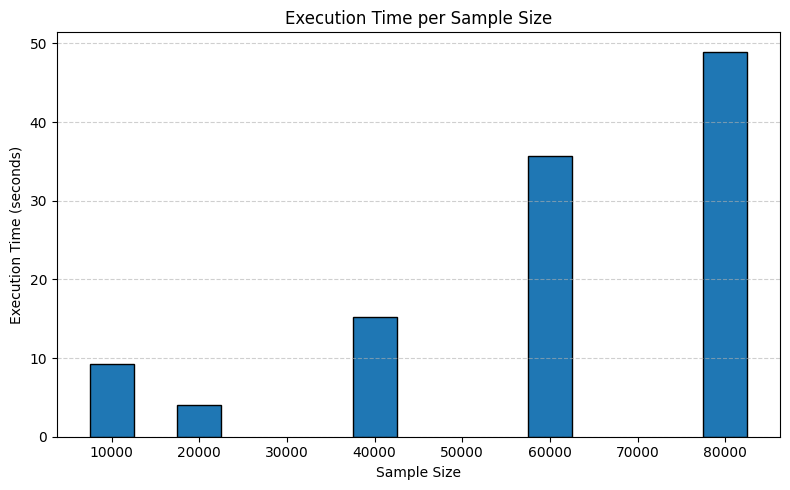

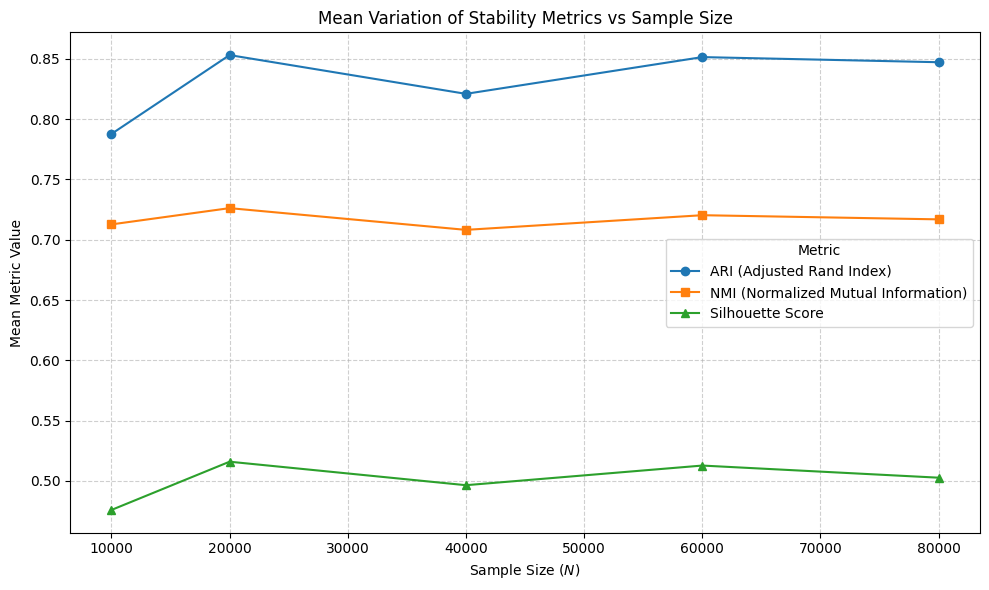

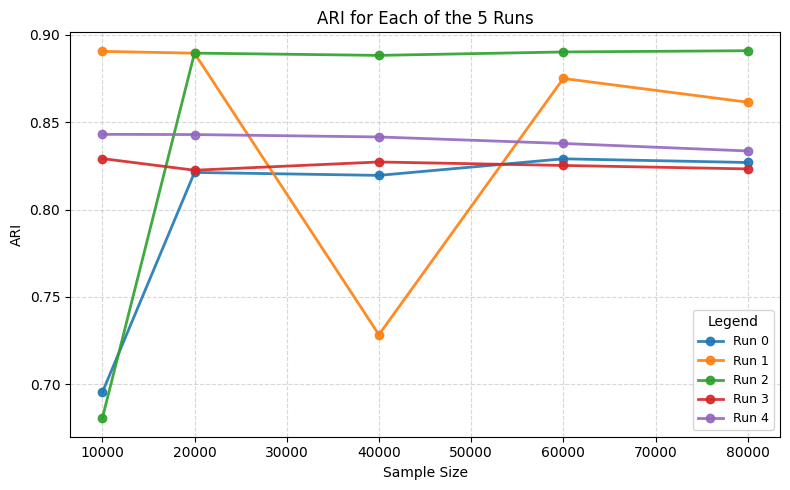

In [4]:

df = pd.read_csv("results/kmeans_results_merged.csv")

# =========================
# 1. Bar chart: Execution Time per Sample Size
# =========================
time_by_sample = df.groupby('sample_size')['time_sec'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(time_by_sample['sample_size'], time_by_sample['time_sec'],   width=5000, edgecolor='black')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time per Sample Size')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/kmeans_execution_time.png')
plt.show()
plt.close()

# =========================
# 2. Line plot: Mean Metrics per Sample Size
# =========================
df_mean = df.groupby('sample_size')[['ari', 'nmi', 'silhouette']].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_mean['sample_size'], df_mean['ari'], marker='o', label='ARI (Adjusted Rand Index)')
plt.plot(df_mean['sample_size'], df_mean['nmi'], marker='s', label='NMI (Normalized Mutual Information)')
plt.plot(df_mean['sample_size'], df_mean['silhouette'], marker='^', label='Silhouette Score')

plt.title('Mean Variation of Stability Metrics vs Sample Size')
plt.xlabel('Sample Size ($N$)')
plt.ylabel('Mean Metric Value')
plt.legend(title='Metric', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/kmeans_line_plot_stability_mean.png')
plt.show()
plt.close()

# =========================
# 3. Line plot: ARI for Each Run
# =========================
plt.figure(figsize=(8,5))

for run_id, group in df.groupby('run'):
    plt.plot(
        group['sample_size'],
        group['ari'],
        marker='o',
        linewidth=2,  # thicker lines
        alpha=0.9,    # more readable
        label=f"Run {run_id}"  # legend
    )

plt.title("ARI for Each of the 5 Runs")
plt.xlabel("Sample Size")
plt.ylabel("ARI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Legend", fontsize=9)
plt.tight_layout()
plt.savefig('results/kmeans_line_plot_ari_stability.png')
plt.show()
plt.close()


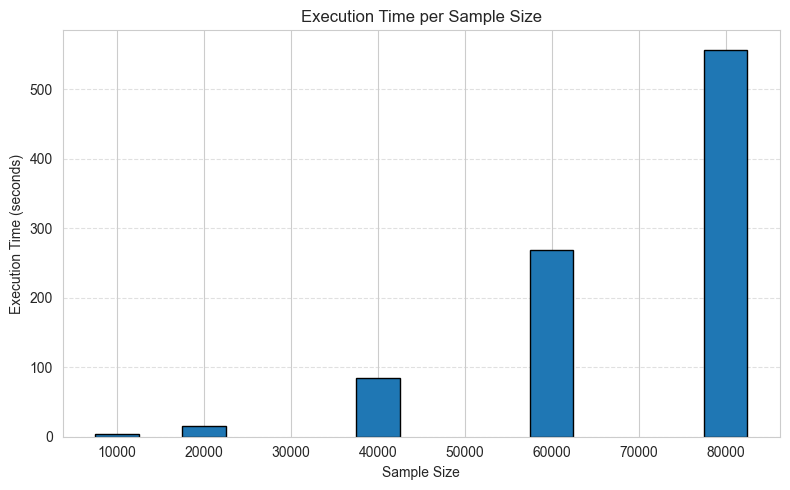

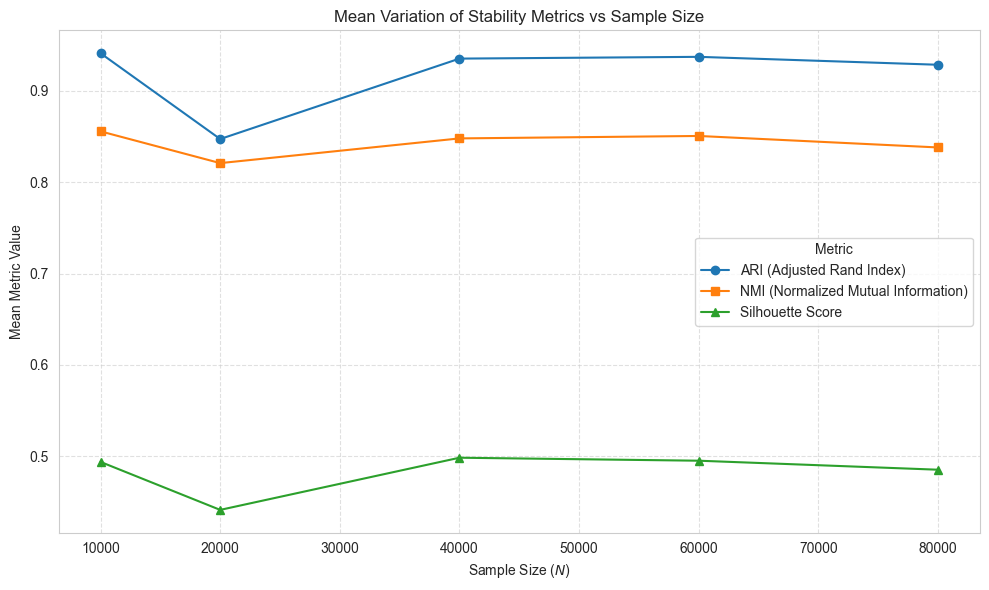

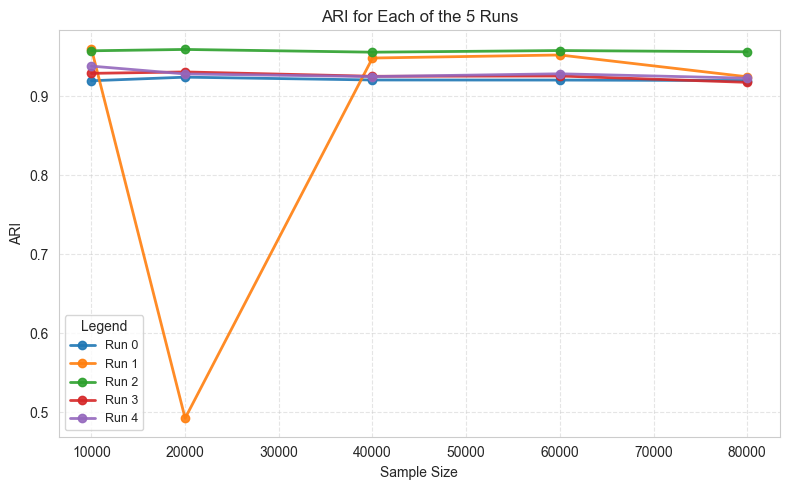

In [16]:

df = pd.read_csv("results/agglomerative_results_merged.csv")

# =========================
# 1. Bar chart: Execution Time per Sample Size
# =========================
time_by_sample = df.groupby('sample_size')['time_sec'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(time_by_sample['sample_size'], time_by_sample['time_sec'],   width=5000, edgecolor='black')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time per Sample Size')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/agglomerative_execution_time.png')
plt.show()
plt.close()

# =========================
# 2. Line plot: Mean Metrics per Sample Size
# =========================
df_mean = df.groupby('sample_size')[['ari', 'nmi', 'silhouette']].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_mean['sample_size'], df_mean['ari'], marker='o', label='ARI (Adjusted Rand Index)')
plt.plot(df_mean['sample_size'], df_mean['nmi'], marker='s', label='NMI (Normalized Mutual Information)')
plt.plot(df_mean['sample_size'], df_mean['silhouette'], marker='^', label='Silhouette Score')

plt.title('Mean Variation of Stability Metrics vs Sample Size')
plt.xlabel('Sample Size ($N$)')
plt.ylabel('Mean Metric Value')
plt.legend(title='Metric', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/agglomerative_line_plot_stability_mean.png')
plt.show()
plt.close()

# =========================
# 3. Line plot: ARI for Each Run
# =========================
plt.figure(figsize=(8,5))

for run_id, group in df.groupby('run'):
    plt.plot(
        group['sample_size'],
        group['ari'],
        marker='o',
        linewidth=2,  # thicker lines
        alpha=0.9,    # more readable
        label=f"Run {run_id}"  # legend
    )

plt.title("ARI for Each of the 5 Runs")
plt.xlabel("Sample Size")
plt.ylabel("ARI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Legend", fontsize=9)
plt.tight_layout()
plt.savefig('results/agglomerative_line_plot_ari_stability.png')
plt.show()
plt.close()

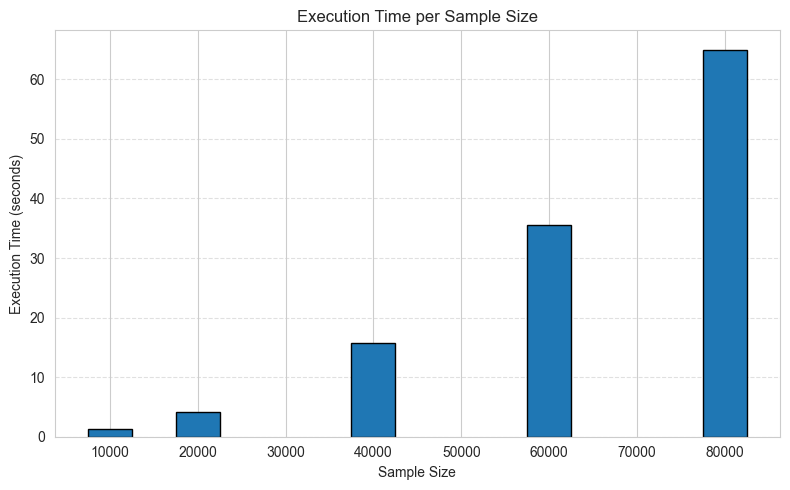

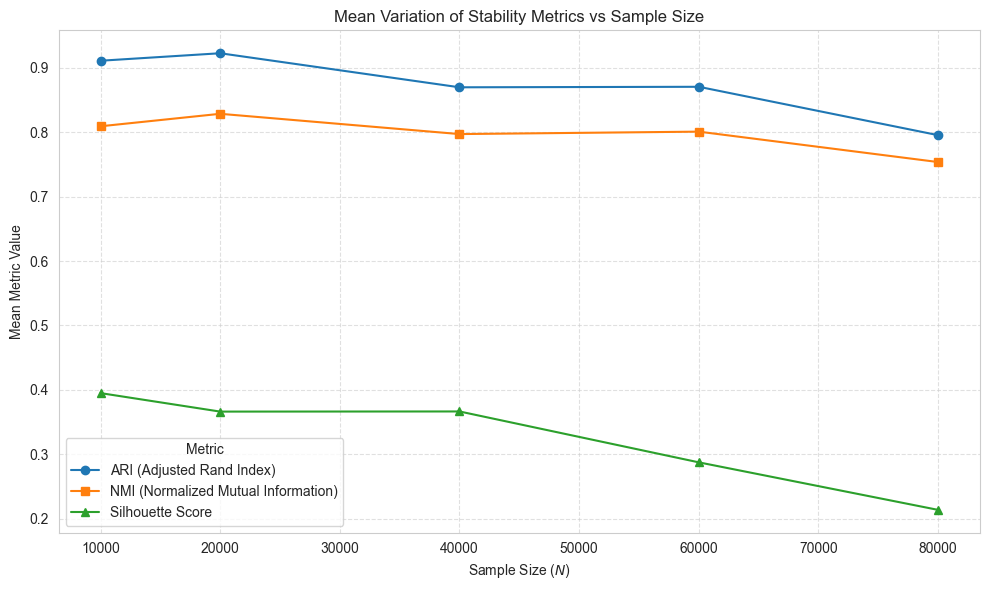

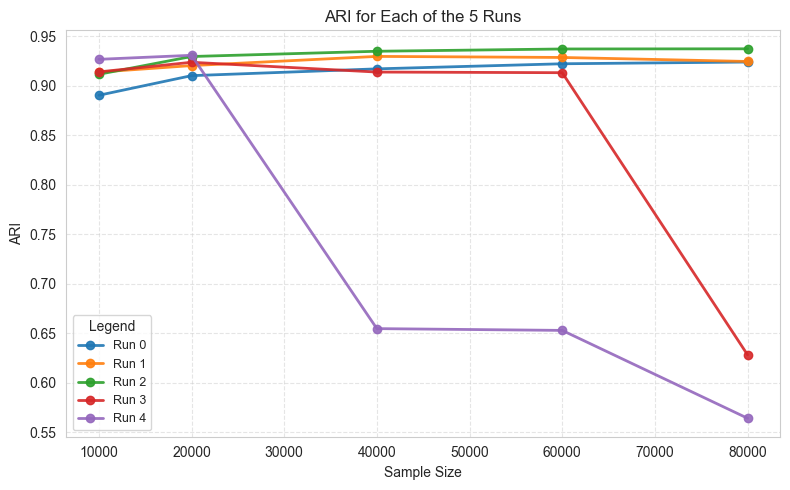

In [15]:

df = pd.read_csv("results/dbscan_results_merged.csv")

# =========================
# 1. Bar chart: Execution Time per Sample Size
# =========================
time_by_sample = df.groupby('sample_size')['time_sec'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(time_by_sample['sample_size'], time_by_sample['time_sec'],   width=5000, edgecolor='black')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time per Sample Size')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/dbscan_execution_time.png')
plt.show()
plt.close()

# =========================
# 2. Line plot: Mean Metrics per Sample Size
# =========================
df_mean = df.groupby('sample_size')[['ari', 'nmi', 'silhouette']].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_mean['sample_size'], df_mean['ari'], marker='o', label='ARI (Adjusted Rand Index)')
plt.plot(df_mean['sample_size'], df_mean['nmi'], marker='s', label='NMI (Normalized Mutual Information)')
plt.plot(df_mean['sample_size'], df_mean['silhouette'], marker='^', label='Silhouette Score')

plt.title('Mean Variation of Stability Metrics vs Sample Size')
plt.xlabel('Sample Size ($N$)')
plt.ylabel('Mean Metric Value')
plt.legend(title='Metric', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/dbscan_line_plot_stability_mean.png')
plt.show()
plt.close()

# =========================
# 3. Line plot: ARI for Each Run
# =========================
plt.figure(figsize=(8,5))

for run_id, group in df.groupby('run'):
    plt.plot(
        group['sample_size'],
        group['ari'],
        marker='o',
        linewidth=2,  # thicker lines
        alpha=0.9,    # more readable
        label=f"Run {run_id}"  # legend
    )

plt.title("ARI for Each of the 5 Runs")
plt.xlabel("Sample Size")
plt.ylabel("ARI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Legend", fontsize=9)
plt.tight_layout()
plt.show()
plt.savefig('results/dbscan_line_plot_ari_stability.png')
plt.close()

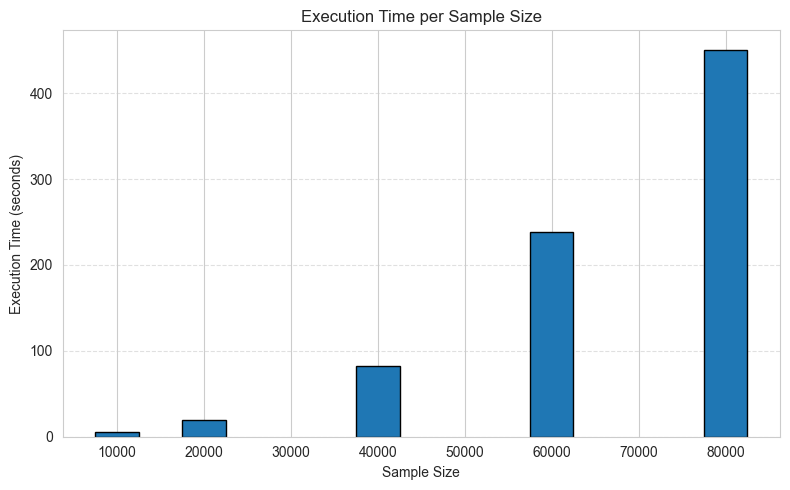

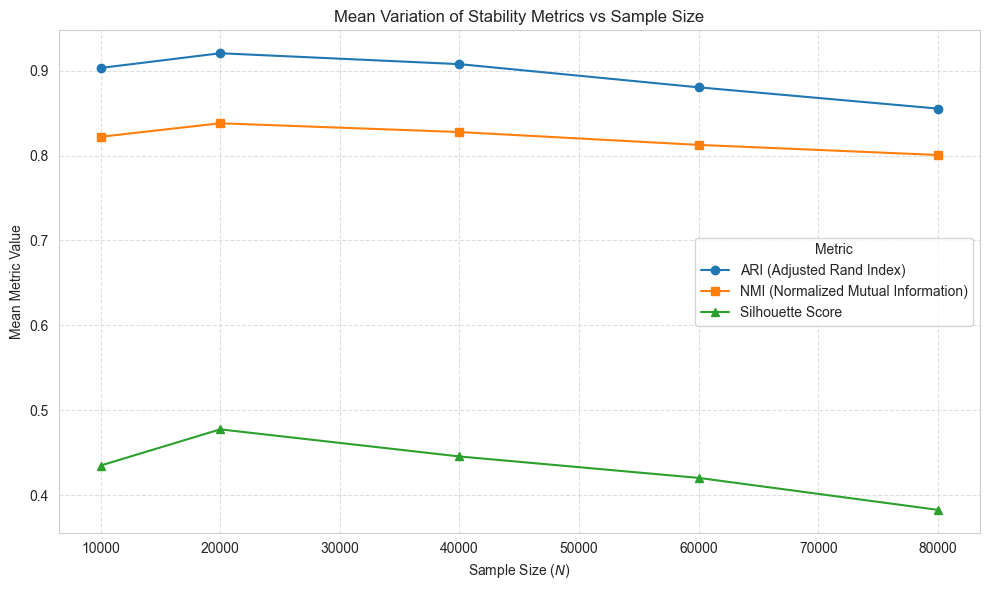

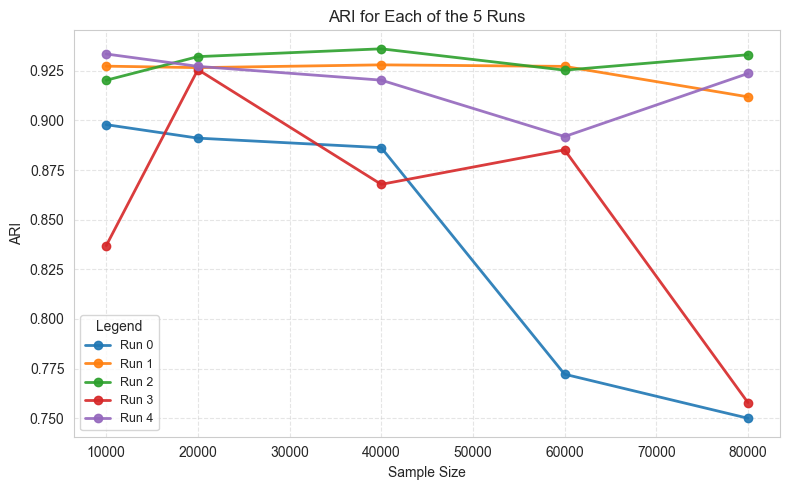

In [14]:

df = pd.read_csv("results/hdbscan_results_merged.csv")

# =========================
# 1. Bar chart: Execution Time per Sample Size
# =========================
time_by_sample = df.groupby('sample_size')['time_sec'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(time_by_sample['sample_size'], time_by_sample['time_sec'],    width=5000, edgecolor='black')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time per Sample Size')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/hdbscan_execution_time.png')
plt.show()
plt.close()

# =========================
# 2. Line plot: Mean Metrics per Sample Size
# =========================
df_mean = df.groupby('sample_size')[['ari', 'nmi', 'silhouette']].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_mean['sample_size'], df_mean['ari'], marker='o', label='ARI (Adjusted Rand Index)')
plt.plot(df_mean['sample_size'], df_mean['nmi'], marker='s', label='NMI (Normalized Mutual Information)')
plt.plot(df_mean['sample_size'], df_mean['silhouette'], marker='^', label='Silhouette Score')

plt.title('Mean Variation of Stability Metrics vs Sample Size')
plt.xlabel('Sample Size ($N$)')
plt.ylabel('Mean Metric Value')
plt.legend(title='Metric', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/hdbscan_line_plot_stability_mean.png')
plt.show()
plt.close()

# =========================
# 3. Line plot: ARI for Each Run
# =========================
plt.figure(figsize=(8,5))

for run_id, group in df.groupby('run'):
    plt.plot(
        group['sample_size'],
        group['ari'],
        marker='o',
        linewidth=2,  # thicker lines
        alpha=0.9,    # more readable
        label=f"Run {run_id}"  # legend
    )

plt.title("ARI for Each of the 5 Runs")
plt.xlabel("Sample Size")
plt.ylabel("ARI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Legend", fontsize=9)
plt.tight_layout()
plt.show()
plt.savefig('results/hdbscan_line_plot_ari_stability.png')
plt.close()

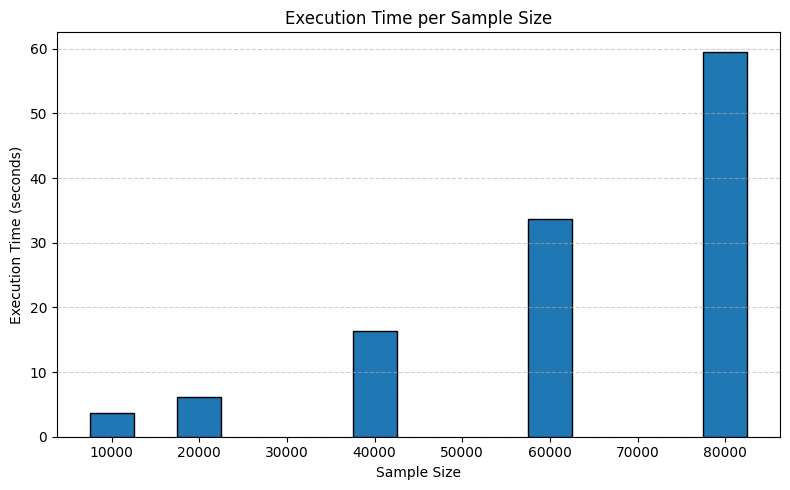

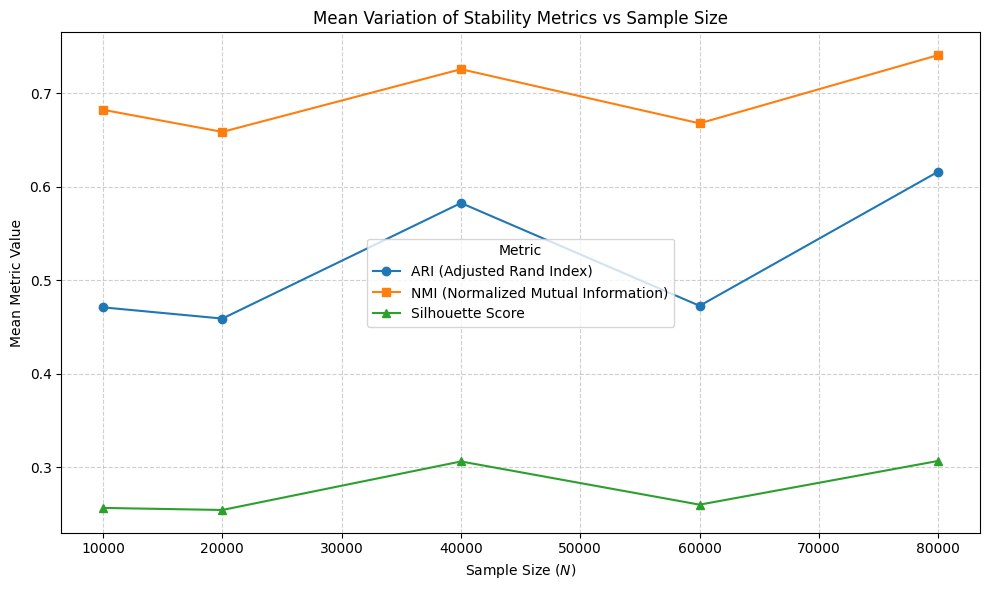

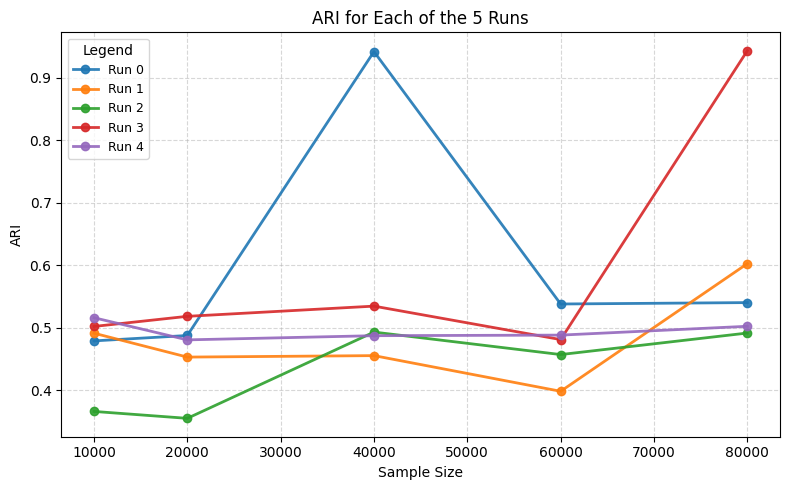

In [5]:

df = pd.read_csv("results/flowsom_results_merged.csv")

# =========================
# 1. Bar chart: Execution Time per Sample Size
# =========================
time_by_sample = df.groupby('sample_size')['time_sec'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(time_by_sample['sample_size'], time_by_sample['time_sec'],    width=5000, edgecolor='black')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time per Sample Size')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/flowsom_execution_time.png')
plt.show()
plt.close()

# =========================
# 2. Line plot: Mean Metrics per Sample Size
# =========================
df_mean = df.groupby('sample_size')[['ari', 'nmi', 'silhouette']].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_mean['sample_size'], df_mean['ari'], marker='o', label='ARI (Adjusted Rand Index)')
plt.plot(df_mean['sample_size'], df_mean['nmi'], marker='s', label='NMI (Normalized Mutual Information)')
plt.plot(df_mean['sample_size'], df_mean['silhouette'], marker='^', label='Silhouette Score')

plt.title('Mean Variation of Stability Metrics vs Sample Size')
plt.xlabel('Sample Size ($N$)')
plt.ylabel('Mean Metric Value')
plt.legend(title='Metric', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/flowsom_line_plot_stability_mean.png')
plt.show()
plt.close()

# =========================
# 3. Line plot: ARI for Each Run
# =========================
plt.figure(figsize=(8,5))

for run_id, group in df.groupby('run'):
    plt.plot(
        group['sample_size'],
        group['ari'],
        marker='o',
        linewidth=2,  # thicker lines
        alpha=0.9,    # more readable
        label=f"Run {run_id}"  # legend
    )

plt.title("ARI for Each of the 5 Runs")
plt.xlabel("Sample Size")
plt.ylabel("ARI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Legend", fontsize=9)
plt.tight_layout()
plt.show()
plt.savefig('results/flowsom_line_plot_ari_stability.png')
plt.close()

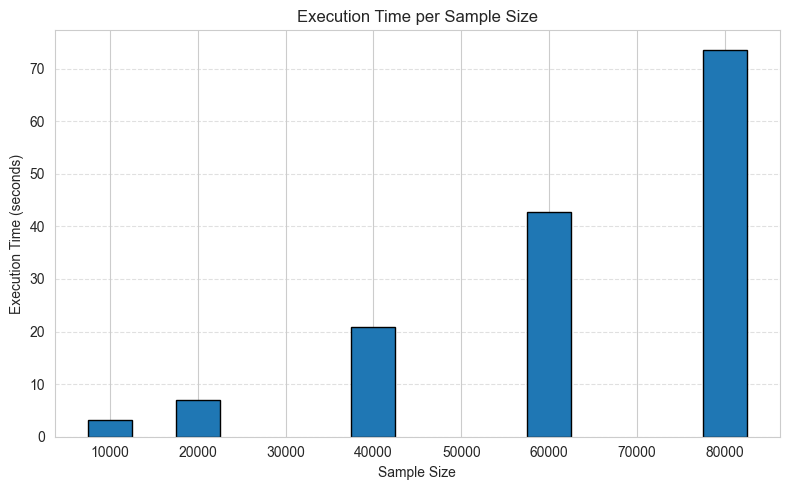

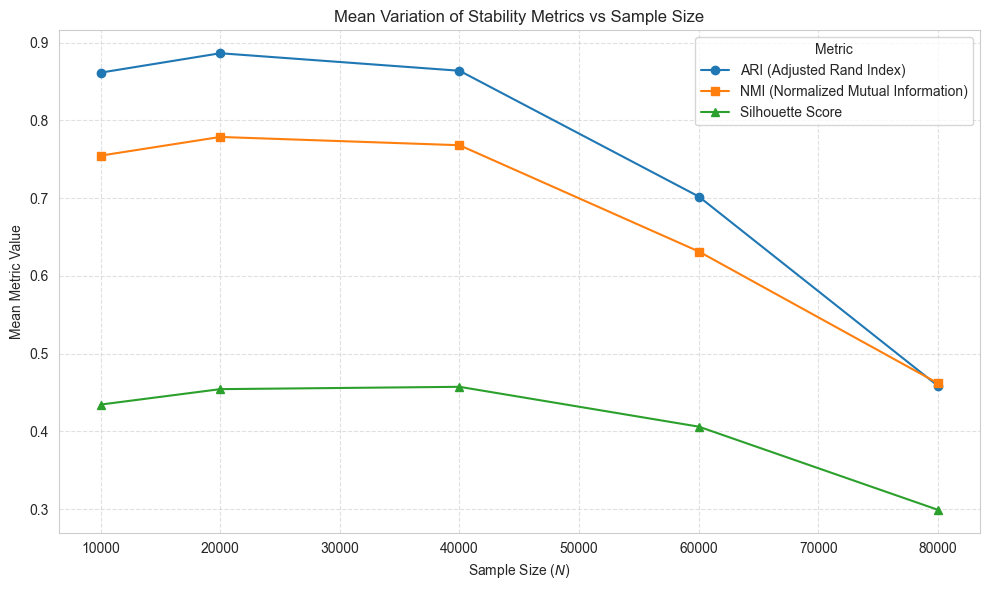

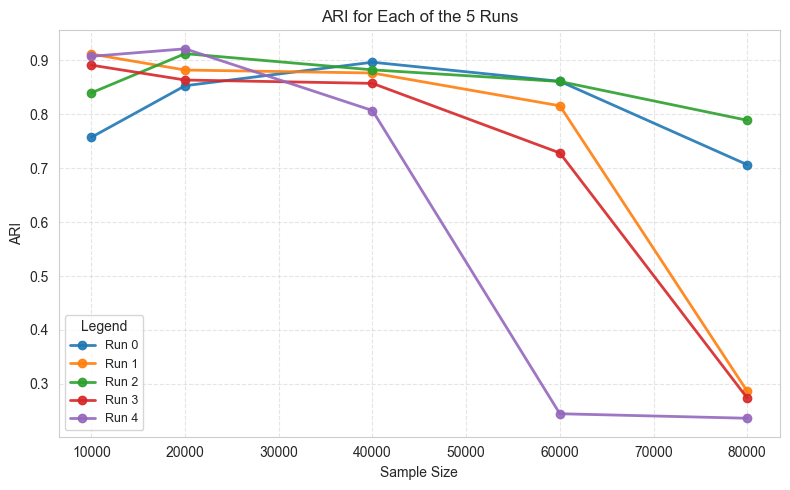

In [12]:

df = pd.read_csv("results/flowgrid_results_merged.csv")

# =========================
# 1. Bar chart: Execution Time per Sample Size
# =========================
time_by_sample = df.groupby('sample_size')['time_sec'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(time_by_sample['sample_size'], time_by_sample['time_sec'], width=5000, edgecolor='black')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time per Sample Size')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/flowgrid_execution_time.png')
plt.show()
plt.close()

# =========================
# 2. Line plot: Mean Metrics per Sample Size
# =========================
df_mean = df.groupby('sample_size')[['ari', 'nmi', 'silhouette']].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_mean['sample_size'], df_mean['ari'], marker='o', label='ARI (Adjusted Rand Index)')
plt.plot(df_mean['sample_size'], df_mean['nmi'], marker='s', label='NMI (Normalized Mutual Information)')
plt.plot(df_mean['sample_size'], df_mean['silhouette'], marker='^', label='Silhouette Score')

plt.title('Mean Variation of Stability Metrics vs Sample Size')
plt.xlabel('Sample Size ($N$)')
plt.ylabel('Mean Metric Value')
plt.legend(title='Metric', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/flowgrid_line_plot_stability_mean.png')
plt.show()
plt.close()

# =========================
# 3. Line plot: ARI for Each Run
# =========================
plt.figure(figsize=(8,5))

for run_id, group in df.groupby('run'):
    plt.plot(
        group['sample_size'],
        group['ari'],
        marker='o',
        linewidth=2,  # thicker lines
        alpha=0.9,    # more readable
        label=f"Run {run_id}"  # legend
    )

plt.title("ARI for Each of the 5 Runs")
plt.xlabel("Sample Size")
plt.ylabel("ARI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Legend", fontsize=9)
plt.tight_layout()
plt.show()
plt.savefig('results/flowgrid_line_plot_ari_stability.png')
plt.close()

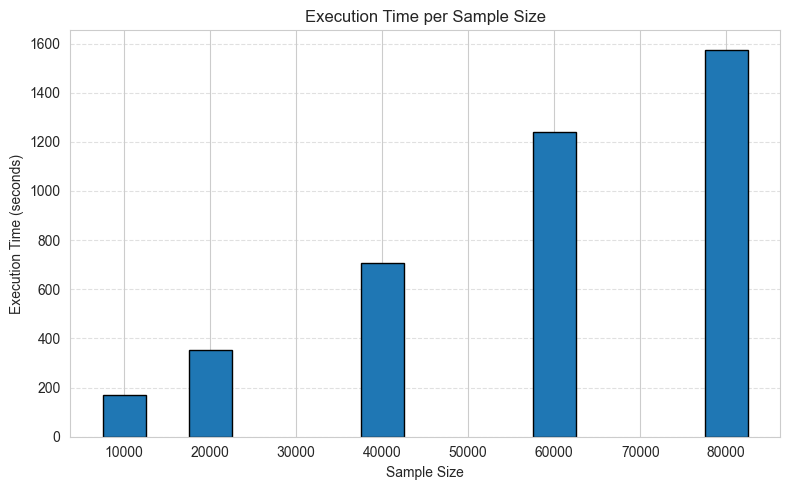

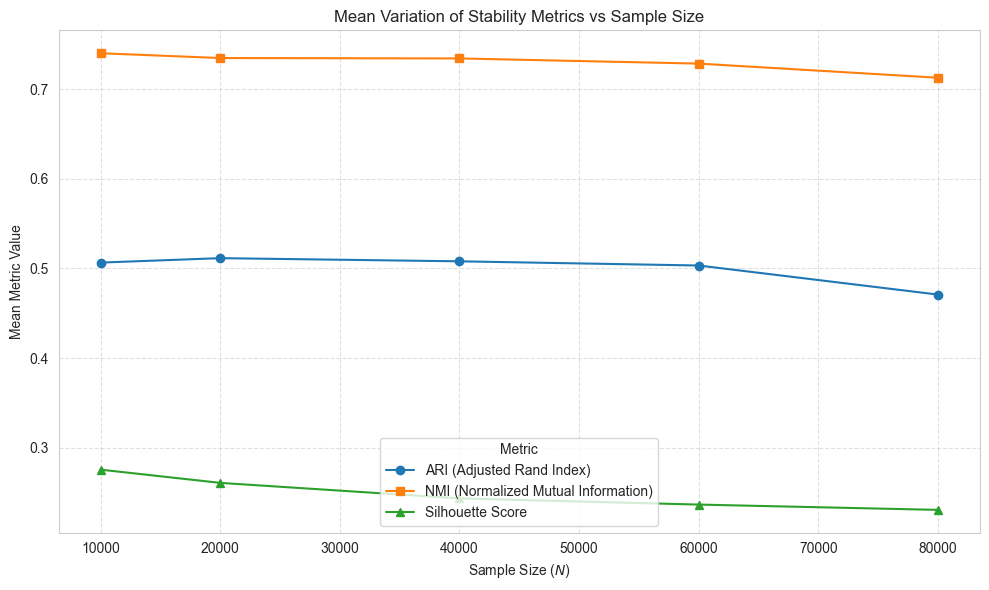

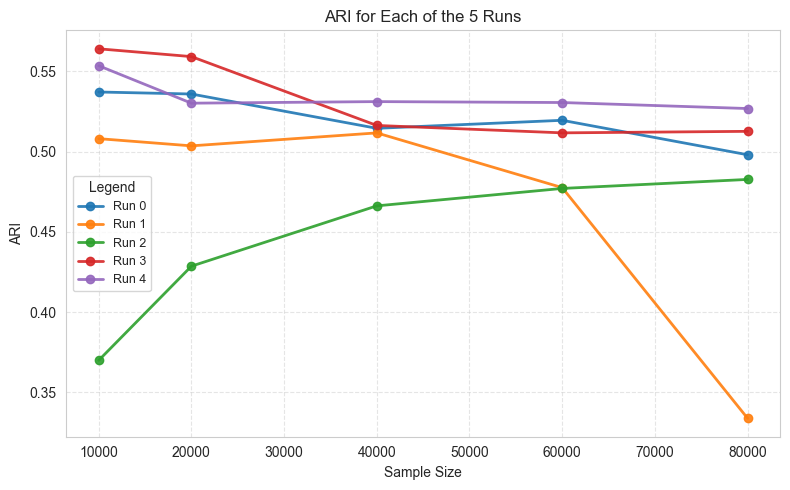

In [18]:


df = pd.read_csv("results/phenograph_results_merged.csv")
# =========================
# 1. Bar chart: Execution Time per Sample Size
# =========================
time_by_sample = df.groupby('sample_size')['time_sec'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(time_by_sample['sample_size'], time_by_sample['time_sec'],   width=5000, edgecolor='black')
plt.xlabel('Sample Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time per Sample Size')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/phenograph_execution_time.png')
plt.show()
plt.close()

# =========================
# 2. Line plot: Mean Metrics per Sample Size
# =========================
df_mean = df.groupby('sample_size')[['ari', 'nmi', 'silhouette']].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_mean['sample_size'], df_mean['ari'], marker='o', label='ARI (Adjusted Rand Index)')
plt.plot(df_mean['sample_size'], df_mean['nmi'], marker='s', label='NMI (Normalized Mutual Information)')
plt.plot(df_mean['sample_size'], df_mean['silhouette'], marker='^', label='Silhouette Score')

plt.title('Mean Variation of Stability Metrics vs Sample Size')
plt.xlabel('Sample Size ($N$)')
plt.ylabel('Mean Metric Value')
plt.legend(title='Metric', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/phenograph_line_plot_stability_mean.png')
plt.show()
plt.close()

# =========================
# 3. Line plot: ARI for Each Run
# =========================
plt.figure(figsize=(8,5))

for run_id, group in df.groupby('run'):
    plt.plot(
        group['sample_size'],
        group['ari'],
        marker='o',
        linewidth=2,  # thicker lines
        alpha=0.9,    # more readable
        label=f"Run {run_id}"  # legend
    )

plt.title("ARI for Each of the 5 Runs")
plt.xlabel("Sample Size")
plt.ylabel("ARI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Legend", fontsize=9)
plt.tight_layout()
plt.show()
plt.savefig('results/phenograph_line_plot_ari_stability.png')
plt.close()

## 5. Comparison clustering methods

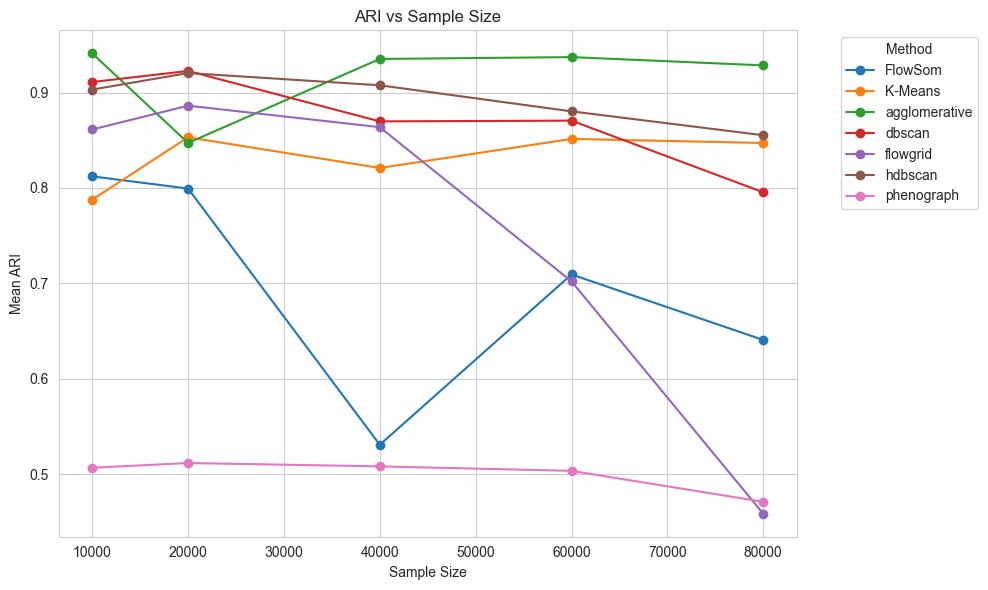

In [ ]:
df_method1 = pd.read_csv("results/kmeans_results_merged.csv")
df_method1['method'] = 'K-Means'

df_method2 = pd.read_csv("results/flowsom_results_merged3.csv")
df_method2['method'] = 'FlowSom'

df_method3 = pd.read_csv("results/agglomerative_results_merged.csv")
df_method3['method'] = 'agglomerative'

df_method4 = pd.read_csv("results/dbscan_results_merged.csv")
df_method4['method'] = 'dbscan'

df_method5 = pd.read_csv("results/hdbscan_results_merged.csv")
df_method5['method'] = 'hdbscan'

df_method6 = pd.read_csv("results/flowgrid_results_merged.csv")
df_method6['method'] = 'flowgrid'

df_method7 = pd.read_csv("results/phenograph_results_merged.csv")
df_method7['method'] = 'phenograph'

df_combined = pd.concat([df_method1, df_method2, df_method3, df_method4, df_method5, df_method6, df_method7], ignore_index=True)


metric = 'ari'  #'ari', 'nmi' or 'silhouette'

summary = df_combined.groupby(['method', 'sample_size']).agg(
    mean_metric=(metric, 'mean'),
    std_metric=(metric, 'std')
).reset_index()

plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

for method in summary['method'].unique():
    method_data = summary[summary['method'] == method]
    plt.errorbar(
        x=method_data['sample_size'],
        y=method_data['mean_metric'],
        label=method,
        marker='o',
        capsize=5,
    )

plt.title(f'{metric.upper()} vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel(f'Mean {metric.upper()}')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  
plt.show()


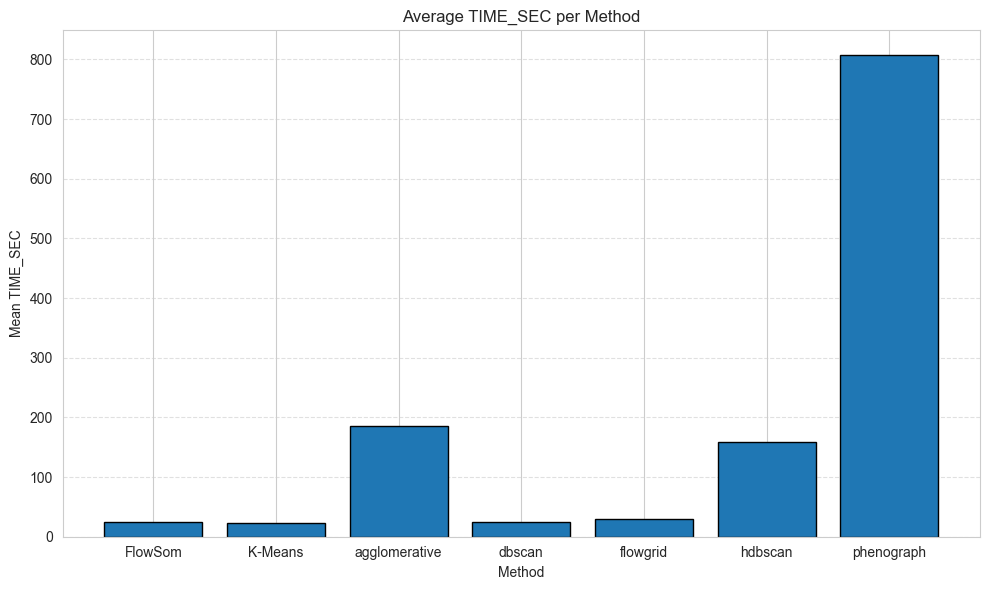

In [ ]:
import matplotlib.pyplot as plt

metric = "time_sec"

method_means = df_combined.groupby("method")[metric].mean().reset_index()

plt.figure(figsize=(10,6))
plt.bar(
    method_means["method"],
    method_means[metric],
    edgecolor="black"
)

plt.xlabel("Method")
plt.ylabel(f"Mean {metric.upper()}")
plt.title(f"Average {metric.upper()} per Method")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
